# 7章　多値分類

In [12]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [13]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [14]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot

In [15]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## 7.7 NLLLoss損失関数

In [16]:
# 入力変数の準備

# 擬似的な出力データ
outputs_np = np.array(range(1, 13)).reshape((4,3))
# 擬似的な正解データ
labels_np = np.array([0, 1, 2, 0])

# Tensor化
outputs = torch.tensor(outputs_np).float()
labels = torch.tensor(labels_np).long()

# 結果確認
print(outputs.data)
print(labels.data)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([0, 1, 2, 0])


In [17]:
# NLLLoss関数の呼び出し

nllloss = nn.NLLLoss()
loss = nllloss(outputs, labels)
print(loss.item())

-6.25


## 7.8 データ準備

### データ読み込み

In [18]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


### データ絞り込み

In [19]:
# データ絞り込み

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]

# 結果確認
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 訓練データ・検証データの分割

In [20]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_select, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


### 訓練データの散布図表示

In [21]:
# データを正解値ごとに分割

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

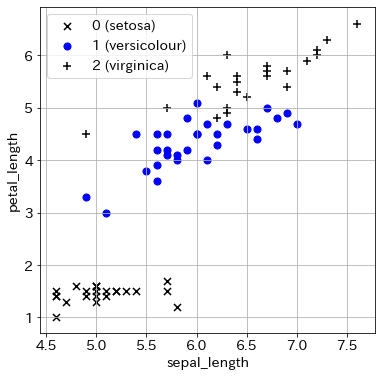

In [22]:
# 散布図の表示

plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## 7.9 モデル定義

In [23]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回は3になる
n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 2  n_output: 3


In [24]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# インスタンスの生成
net = Net(n_input, n_output)        

### モデル確認

In [25]:
# モデル内のパラメータの確認
# l1.weightが行列にl1.biasがベクトルになっている

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [26]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=3, bias=True)
)


In [27]:
# モデルのサマリー表示

summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
Total params: 9
Trainable params: 9
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### 最適化アルゴリズムと損失関数

In [28]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

## 7.10 勾配降下法

### データのTensor化

In [29]:
# 入力変数x_trainと正解値 y_trainのTesor化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のTensor化

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

### 計算グラフの視覚化

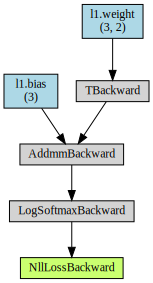

In [30]:
# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失関数の計算グラフ化
make_dot(loss, params=dict(net.named_parameters()))

### 予測ラベル値の取得方法

In [31]:
# torch.max関数呼び出し
# 2つめの引数は軸を意味している。1だと行ごとの集計。
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [32]:
# ラベル値の配列を取得
torch.max(outputs, 1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

### 繰り返し計算

In [33]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [34]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ
    with torch.no_grad():

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels_test)

        #予測値算出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss =  loss_test.item()
        val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( (epoch) % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09263, val_acc: 0.26667
Epoch [10/10000], loss: 1.03580 acc: 0.40000 val_loss: 1.06403, val_acc: 0.26667
Epoch [20/10000], loss: 1.00477 acc: 0.40000 val_loss: 1.03347, val_acc: 0.26667
Epoch [30/10000], loss: 0.97672 acc: 0.40000 val_loss: 1.00264, val_acc: 0.26667
Epoch [40/10000], loss: 0.95057 acc: 0.41333 val_loss: 0.97351, val_acc: 0.26667
Epoch [50/10000], loss: 0.92616 acc: 0.48000 val_loss: 0.94631, val_acc: 0.38667
Epoch [60/10000], loss: 0.90338 acc: 0.69333 val_loss: 0.92098, val_acc: 0.56000
Epoch [70/10000], loss: 0.88212 acc: 0.70667 val_loss: 0.89740, val_acc: 0.60000
Epoch [80/10000], loss: 0.86227 acc: 0.70667 val_loss: 0.87545, val_acc: 0.61333
Epoch [90/10000], loss: 0.84373 acc: 0.70667 val_loss: 0.85500, val_acc: 0.62667
Epoch [100/10000], loss: 0.82640 acc: 0.70667 val_loss: 0.83594, val_acc: 0.62667
Epoch [110/10000], loss: 0.81019 acc: 0.72000 val_loss: 0.81815, val_acc: 0.62667
Epoch [120/10000], loss: 0.

Epoch [1110/10000], loss: 0.44133 acc: 0.89333 val_loss: 0.42790, val_acc: 0.92000
Epoch [1120/10000], loss: 0.44020 acc: 0.89333 val_loss: 0.42676, val_acc: 0.92000
Epoch [1130/10000], loss: 0.43908 acc: 0.89333 val_loss: 0.42562, val_acc: 0.92000
Epoch [1140/10000], loss: 0.43797 acc: 0.89333 val_loss: 0.42450, val_acc: 0.92000
Epoch [1150/10000], loss: 0.43687 acc: 0.89333 val_loss: 0.42339, val_acc: 0.92000
Epoch [1160/10000], loss: 0.43578 acc: 0.89333 val_loss: 0.42229, val_acc: 0.92000
Epoch [1170/10000], loss: 0.43470 acc: 0.89333 val_loss: 0.42120, val_acc: 0.92000
Epoch [1180/10000], loss: 0.43363 acc: 0.89333 val_loss: 0.42012, val_acc: 0.92000
Epoch [1190/10000], loss: 0.43257 acc: 0.89333 val_loss: 0.41905, val_acc: 0.92000
Epoch [1200/10000], loss: 0.43152 acc: 0.89333 val_loss: 0.41799, val_acc: 0.92000
Epoch [1210/10000], loss: 0.43048 acc: 0.89333 val_loss: 0.41694, val_acc: 0.92000
Epoch [1220/10000], loss: 0.42945 acc: 0.89333 val_loss: 0.41590, val_acc: 0.92000
Epoc

Epoch [2240/10000], loss: 0.35514 acc: 0.90667 val_loss: 0.34116, val_acc: 0.94667
Epoch [2250/10000], loss: 0.35461 acc: 0.90667 val_loss: 0.34063, val_acc: 0.94667
Epoch [2260/10000], loss: 0.35409 acc: 0.90667 val_loss: 0.34010, val_acc: 0.94667
Epoch [2270/10000], loss: 0.35356 acc: 0.90667 val_loss: 0.33958, val_acc: 0.94667
Epoch [2280/10000], loss: 0.35304 acc: 0.90667 val_loss: 0.33905, val_acc: 0.94667
Epoch [2290/10000], loss: 0.35253 acc: 0.90667 val_loss: 0.33853, val_acc: 0.94667
Epoch [2300/10000], loss: 0.35201 acc: 0.90667 val_loss: 0.33802, val_acc: 0.94667
Epoch [2310/10000], loss: 0.35150 acc: 0.90667 val_loss: 0.33750, val_acc: 0.94667
Epoch [2320/10000], loss: 0.35099 acc: 0.90667 val_loss: 0.33699, val_acc: 0.94667
Epoch [2330/10000], loss: 0.35048 acc: 0.90667 val_loss: 0.33648, val_acc: 0.94667
Epoch [2340/10000], loss: 0.34998 acc: 0.90667 val_loss: 0.33597, val_acc: 0.94667
Epoch [2350/10000], loss: 0.34947 acc: 0.90667 val_loss: 0.33546, val_acc: 0.94667
Epoc

Epoch [3320/10000], loss: 0.31018 acc: 0.90667 val_loss: 0.29581, val_acc: 0.94667
Epoch [3330/10000], loss: 0.30985 acc: 0.90667 val_loss: 0.29548, val_acc: 0.94667
Epoch [3340/10000], loss: 0.30953 acc: 0.90667 val_loss: 0.29515, val_acc: 0.94667
Epoch [3350/10000], loss: 0.30920 acc: 0.90667 val_loss: 0.29482, val_acc: 0.94667
Epoch [3360/10000], loss: 0.30888 acc: 0.90667 val_loss: 0.29449, val_acc: 0.94667
Epoch [3370/10000], loss: 0.30856 acc: 0.90667 val_loss: 0.29416, val_acc: 0.94667
Epoch [3380/10000], loss: 0.30824 acc: 0.90667 val_loss: 0.29384, val_acc: 0.94667
Epoch [3390/10000], loss: 0.30792 acc: 0.90667 val_loss: 0.29351, val_acc: 0.94667
Epoch [3400/10000], loss: 0.30760 acc: 0.90667 val_loss: 0.29319, val_acc: 0.94667
Epoch [3410/10000], loss: 0.30728 acc: 0.90667 val_loss: 0.29287, val_acc: 0.94667
Epoch [3420/10000], loss: 0.30696 acc: 0.90667 val_loss: 0.29255, val_acc: 0.94667
Epoch [3430/10000], loss: 0.30665 acc: 0.90667 val_loss: 0.29223, val_acc: 0.94667
Epoc

Epoch [4520/10000], loss: 0.27835 acc: 0.90667 val_loss: 0.26337, val_acc: 0.96000
Epoch [4530/10000], loss: 0.27814 acc: 0.90667 val_loss: 0.26315, val_acc: 0.96000
Epoch [4540/10000], loss: 0.27792 acc: 0.90667 val_loss: 0.26293, val_acc: 0.96000
Epoch [4550/10000], loss: 0.27771 acc: 0.90667 val_loss: 0.26271, val_acc: 0.96000
Epoch [4560/10000], loss: 0.27750 acc: 0.90667 val_loss: 0.26249, val_acc: 0.96000
Epoch [4570/10000], loss: 0.27729 acc: 0.90667 val_loss: 0.26228, val_acc: 0.96000
Epoch [4580/10000], loss: 0.27708 acc: 0.90667 val_loss: 0.26206, val_acc: 0.96000
Epoch [4590/10000], loss: 0.27687 acc: 0.90667 val_loss: 0.26185, val_acc: 0.96000
Epoch [4600/10000], loss: 0.27666 acc: 0.90667 val_loss: 0.26163, val_acc: 0.96000
Epoch [4610/10000], loss: 0.27645 acc: 0.90667 val_loss: 0.26142, val_acc: 0.96000
Epoch [4620/10000], loss: 0.27624 acc: 0.90667 val_loss: 0.26120, val_acc: 0.96000
Epoch [4630/10000], loss: 0.27603 acc: 0.90667 val_loss: 0.26099, val_acc: 0.96000
Epoc

Epoch [5560/10000], loss: 0.25923 acc: 0.90667 val_loss: 0.24366, val_acc: 0.96000
Epoch [5570/10000], loss: 0.25907 acc: 0.90667 val_loss: 0.24349, val_acc: 0.96000
Epoch [5580/10000], loss: 0.25891 acc: 0.90667 val_loss: 0.24333, val_acc: 0.96000
Epoch [5590/10000], loss: 0.25876 acc: 0.90667 val_loss: 0.24317, val_acc: 0.96000
Epoch [5600/10000], loss: 0.25860 acc: 0.90667 val_loss: 0.24301, val_acc: 0.96000
Epoch [5610/10000], loss: 0.25845 acc: 0.90667 val_loss: 0.24285, val_acc: 0.96000
Epoch [5620/10000], loss: 0.25829 acc: 0.90667 val_loss: 0.24268, val_acc: 0.96000
Epoch [5630/10000], loss: 0.25814 acc: 0.90667 val_loss: 0.24252, val_acc: 0.96000
Epoch [5640/10000], loss: 0.25798 acc: 0.90667 val_loss: 0.24236, val_acc: 0.96000
Epoch [5650/10000], loss: 0.25783 acc: 0.90667 val_loss: 0.24220, val_acc: 0.96000
Epoch [5660/10000], loss: 0.25767 acc: 0.90667 val_loss: 0.24205, val_acc: 0.96000
Epoch [5670/10000], loss: 0.25752 acc: 0.90667 val_loss: 0.24189, val_acc: 0.96000
Epoc

Epoch [6670/10000], loss: 0.24406 acc: 0.90667 val_loss: 0.22785, val_acc: 0.96000
Epoch [6680/10000], loss: 0.24394 acc: 0.90667 val_loss: 0.22773, val_acc: 0.96000
Epoch [6690/10000], loss: 0.24382 acc: 0.90667 val_loss: 0.22761, val_acc: 0.96000
Epoch [6700/10000], loss: 0.24370 acc: 0.90667 val_loss: 0.22748, val_acc: 0.96000
Epoch [6710/10000], loss: 0.24359 acc: 0.90667 val_loss: 0.22736, val_acc: 0.96000
Epoch [6720/10000], loss: 0.24347 acc: 0.90667 val_loss: 0.22724, val_acc: 0.96000
Epoch [6730/10000], loss: 0.24335 acc: 0.90667 val_loss: 0.22711, val_acc: 0.96000
Epoch [6740/10000], loss: 0.24324 acc: 0.90667 val_loss: 0.22699, val_acc: 0.96000
Epoch [6750/10000], loss: 0.24312 acc: 0.90667 val_loss: 0.22687, val_acc: 0.96000
Epoch [6760/10000], loss: 0.24300 acc: 0.90667 val_loss: 0.22675, val_acc: 0.96000
Epoch [6770/10000], loss: 0.24289 acc: 0.90667 val_loss: 0.22663, val_acc: 0.96000
Epoch [6780/10000], loss: 0.24277 acc: 0.90667 val_loss: 0.22651, val_acc: 0.96000
Epoc

Epoch [7900/10000], loss: 0.23135 acc: 0.90667 val_loss: 0.21447, val_acc: 0.96000
Epoch [7910/10000], loss: 0.23126 acc: 0.90667 val_loss: 0.21437, val_acc: 0.96000
Epoch [7920/10000], loss: 0.23117 acc: 0.90667 val_loss: 0.21428, val_acc: 0.96000
Epoch [7930/10000], loss: 0.23108 acc: 0.90667 val_loss: 0.21418, val_acc: 0.96000
Epoch [7940/10000], loss: 0.23099 acc: 0.90667 val_loss: 0.21409, val_acc: 0.96000
Epoch [7950/10000], loss: 0.23091 acc: 0.90667 val_loss: 0.21400, val_acc: 0.96000
Epoch [7960/10000], loss: 0.23082 acc: 0.90667 val_loss: 0.21390, val_acc: 0.96000
Epoch [7970/10000], loss: 0.23073 acc: 0.90667 val_loss: 0.21381, val_acc: 0.96000
Epoch [7980/10000], loss: 0.23064 acc: 0.90667 val_loss: 0.21371, val_acc: 0.96000
Epoch [7990/10000], loss: 0.23055 acc: 0.90667 val_loss: 0.21362, val_acc: 0.96000
Epoch [8000/10000], loss: 0.23046 acc: 0.90667 val_loss: 0.21353, val_acc: 0.96000
Epoch [8010/10000], loss: 0.23037 acc: 0.90667 val_loss: 0.21343, val_acc: 0.96000
Epoc

Epoch [8930/10000], loss: 0.22298 acc: 0.90667 val_loss: 0.20556, val_acc: 0.96000
Epoch [8940/10000], loss: 0.22291 acc: 0.90667 val_loss: 0.20548, val_acc: 0.96000
Epoch [8950/10000], loss: 0.22283 acc: 0.90667 val_loss: 0.20540, val_acc: 0.96000
Epoch [8960/10000], loss: 0.22276 acc: 0.90667 val_loss: 0.20532, val_acc: 0.96000
Epoch [8970/10000], loss: 0.22269 acc: 0.90667 val_loss: 0.20524, val_acc: 0.96000
Epoch [8980/10000], loss: 0.22261 acc: 0.90667 val_loss: 0.20517, val_acc: 0.96000
Epoch [8990/10000], loss: 0.22254 acc: 0.90667 val_loss: 0.20509, val_acc: 0.96000
Epoch [9000/10000], loss: 0.22247 acc: 0.90667 val_loss: 0.20501, val_acc: 0.96000
Epoch [9010/10000], loss: 0.22240 acc: 0.90667 val_loss: 0.20493, val_acc: 0.96000
Epoch [9020/10000], loss: 0.22232 acc: 0.90667 val_loss: 0.20485, val_acc: 0.96000
Epoch [9030/10000], loss: 0.22225 acc: 0.90667 val_loss: 0.20478, val_acc: 0.96000
Epoch [9040/10000], loss: 0.22218 acc: 0.90667 val_loss: 0.20470, val_acc: 0.96000
Epoc

Epoch [9940/10000], loss: 0.21620 acc: 0.90667 val_loss: 0.19828, val_acc: 0.96000
Epoch [9950/10000], loss: 0.21614 acc: 0.90667 val_loss: 0.19821, val_acc: 0.96000
Epoch [9960/10000], loss: 0.21608 acc: 0.90667 val_loss: 0.19815, val_acc: 0.96000
Epoch [9970/10000], loss: 0.21602 acc: 0.90667 val_loss: 0.19808, val_acc: 0.96000
Epoch [9980/10000], loss: 0.21596 acc: 0.90667 val_loss: 0.19802, val_acc: 0.96000
Epoch [9990/10000], loss: 0.21590 acc: 0.90667 val_loss: 0.19795, val_acc: 0.96000


## 7.11 結果確認

In [35]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09263 精度: 0.26667
最終状態: 損失関数: 0.19795 精度: 0.96000


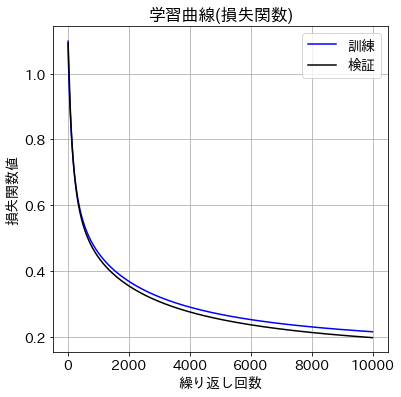

In [36]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

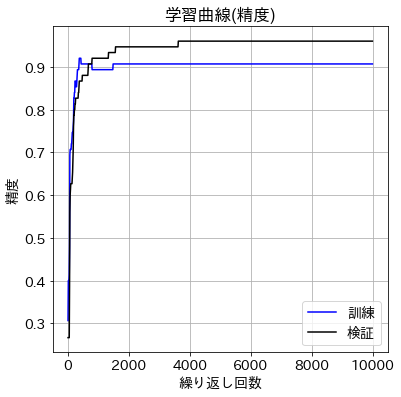

In [37]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### モデルへの入力と出力の確認

In [38]:
# 正解ラベルの0番目、2番目、3番目

print(labels[[0,2,3]])

tensor([1, 0, 2])


In [39]:
# 該当する入力値を抽出

i3 = inputs[[0,2,3],:]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [40]:
# 出力値にsoftmax関数をかけた結果を取得

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[ 8.8071 14.1938 12.9986]
 [12.8262  9.8     0.1734]
 [ 6.7954 15.0928 17.1111]]
[[0.0035 0.765  0.2315]
 [0.9537 0.0463 0.    ]
 [0.     0.1173 0.8827]]


### 最終的な重み行列とバイアスの値

In [41]:
# 重み行列
print(net.l1.weight.data)

# バイアス
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


## 7.11 入力変数の4次元化

In [42]:
# 学習データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]

(75, 4) (75, 4) (75,) (75,)


In [43]:
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

入力データ(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
入力次元数: 4


In [44]:
# 入力変数x_trainと正解値 y_trainのTesor化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用変数のTensor化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [45]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [46]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ
    with torch.no_grad():

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        # loss_test = criterion(torch.log(outputs_test), labels_test)
        loss_test = criterion(outputs_test, labels_test)

        #予測値算出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss =  loss_test.item()
        val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

Epoch [1060/10000], loss: 0.36311 acc: 0.97333 val_loss: 0.35258, val_acc: 0.96000
Epoch [1070/10000], loss: 0.36183 acc: 0.97333 val_loss: 0.35135, val_acc: 0.96000
Epoch [1080/10000], loss: 0.36056 acc: 0.97333 val_loss: 0.35014, val_acc: 0.96000
Epoch [1090/10000], loss: 0.35930 acc: 0.97333 val_loss: 0.34895, val_acc: 0.96000
Epoch [1100/10000], loss: 0.35805 acc: 0.97333 val_loss: 0.34776, val_acc: 0.96000
Epoch [1110/10000], loss: 0.35682 acc: 0.97333 val_loss: 0.34659, val_acc: 0.96000
Epoch [1120/10000], loss: 0.35559 acc: 0.97333 val_loss: 0.34542, val_acc: 0.96000
Epoch [1130/10000], loss: 0.35438 acc: 0.97333 val_loss: 0.34427, val_acc: 0.96000
Epoch [1140/10000], loss: 0.35318 acc: 0.97333 val_loss: 0.34313, val_acc: 0.96000
Epoch [1150/10000], loss: 0.35199 acc: 0.97333 val_loss: 0.34199, val_acc: 0.96000
Epoch [1160/10000], loss: 0.35081 acc: 0.97333 val_loss: 0.34087, val_acc: 0.96000
Epoch [1170/10000], loss: 0.34964 acc: 0.97333 val_loss: 0.33976, val_acc: 0.96000
Epoc

Epoch [2170/10000], loss: 0.26760 acc: 0.97333 val_loss: 0.26289, val_acc: 0.96000
Epoch [2180/10000], loss: 0.26702 acc: 0.97333 val_loss: 0.26236, val_acc: 0.96000
Epoch [2190/10000], loss: 0.26644 acc: 0.97333 val_loss: 0.26182, val_acc: 0.96000
Epoch [2200/10000], loss: 0.26587 acc: 0.97333 val_loss: 0.26129, val_acc: 0.96000
Epoch [2210/10000], loss: 0.26530 acc: 0.97333 val_loss: 0.26077, val_acc: 0.96000
Epoch [2220/10000], loss: 0.26473 acc: 0.97333 val_loss: 0.26024, val_acc: 0.96000
Epoch [2230/10000], loss: 0.26417 acc: 0.97333 val_loss: 0.25972, val_acc: 0.96000
Epoch [2240/10000], loss: 0.26361 acc: 0.97333 val_loss: 0.25921, val_acc: 0.96000
Epoch [2250/10000], loss: 0.26305 acc: 0.97333 val_loss: 0.25869, val_acc: 0.96000
Epoch [2260/10000], loss: 0.26250 acc: 0.97333 val_loss: 0.25818, val_acc: 0.96000
Epoch [2270/10000], loss: 0.26195 acc: 0.97333 val_loss: 0.25767, val_acc: 0.96000
Epoch [2280/10000], loss: 0.26140 acc: 0.97333 val_loss: 0.25717, val_acc: 0.96000
Epoc

Epoch [3400/10000], loss: 0.21487 acc: 0.98667 val_loss: 0.21454, val_acc: 0.96000
Epoch [3410/10000], loss: 0.21455 acc: 0.98667 val_loss: 0.21425, val_acc: 0.96000
Epoch [3420/10000], loss: 0.21424 acc: 0.98667 val_loss: 0.21397, val_acc: 0.96000
Epoch [3430/10000], loss: 0.21392 acc: 0.98667 val_loss: 0.21368, val_acc: 0.96000
Epoch [3440/10000], loss: 0.21361 acc: 0.98667 val_loss: 0.21340, val_acc: 0.96000
Epoch [3450/10000], loss: 0.21330 acc: 0.98667 val_loss: 0.21312, val_acc: 0.96000
Epoch [3460/10000], loss: 0.21299 acc: 0.98667 val_loss: 0.21284, val_acc: 0.96000
Epoch [3470/10000], loss: 0.21268 acc: 0.98667 val_loss: 0.21256, val_acc: 0.96000
Epoch [3480/10000], loss: 0.21238 acc: 0.98667 val_loss: 0.21228, val_acc: 0.96000
Epoch [3490/10000], loss: 0.21207 acc: 0.98667 val_loss: 0.21200, val_acc: 0.96000
Epoch [3500/10000], loss: 0.21177 acc: 0.98667 val_loss: 0.21173, val_acc: 0.96000
Epoch [3510/10000], loss: 0.21146 acc: 0.98667 val_loss: 0.21145, val_acc: 0.96000
Epoc

Epoch [4430/10000], loss: 0.18811 acc: 0.98667 val_loss: 0.19041, val_acc: 0.96000
Epoch [4440/10000], loss: 0.18789 acc: 0.98667 val_loss: 0.19021, val_acc: 0.96000
Epoch [4450/10000], loss: 0.18768 acc: 0.98667 val_loss: 0.19002, val_acc: 0.96000
Epoch [4460/10000], loss: 0.18747 acc: 0.98667 val_loss: 0.18984, val_acc: 0.96000
Epoch [4470/10000], loss: 0.18726 acc: 0.98667 val_loss: 0.18965, val_acc: 0.96000
Epoch [4480/10000], loss: 0.18705 acc: 0.98667 val_loss: 0.18946, val_acc: 0.96000
Epoch [4490/10000], loss: 0.18684 acc: 0.98667 val_loss: 0.18927, val_acc: 0.96000
Epoch [4500/10000], loss: 0.18663 acc: 0.98667 val_loss: 0.18908, val_acc: 0.96000
Epoch [4510/10000], loss: 0.18642 acc: 0.98667 val_loss: 0.18890, val_acc: 0.96000
Epoch [4520/10000], loss: 0.18622 acc: 0.98667 val_loss: 0.18871, val_acc: 0.96000
Epoch [4530/10000], loss: 0.18601 acc: 0.98667 val_loss: 0.18853, val_acc: 0.96000
Epoch [4540/10000], loss: 0.18580 acc: 0.98667 val_loss: 0.18834, val_acc: 0.96000
Epoc

Epoch [5480/10000], loss: 0.16913 acc: 0.98667 val_loss: 0.17352, val_acc: 0.96000
Epoch [5490/10000], loss: 0.16898 acc: 0.98667 val_loss: 0.17339, val_acc: 0.96000
Epoch [5500/10000], loss: 0.16883 acc: 0.98667 val_loss: 0.17325, val_acc: 0.96000
Epoch [5510/10000], loss: 0.16867 acc: 0.98667 val_loss: 0.17312, val_acc: 0.96000
Epoch [5520/10000], loss: 0.16852 acc: 0.98667 val_loss: 0.17299, val_acc: 0.96000
Epoch [5530/10000], loss: 0.16837 acc: 0.98667 val_loss: 0.17285, val_acc: 0.96000
Epoch [5540/10000], loss: 0.16822 acc: 0.98667 val_loss: 0.17272, val_acc: 0.96000
Epoch [5550/10000], loss: 0.16807 acc: 0.98667 val_loss: 0.17259, val_acc: 0.96000
Epoch [5560/10000], loss: 0.16792 acc: 0.98667 val_loss: 0.17246, val_acc: 0.96000
Epoch [5570/10000], loss: 0.16777 acc: 0.98667 val_loss: 0.17232, val_acc: 0.96000
Epoch [5580/10000], loss: 0.16762 acc: 0.98667 val_loss: 0.17219, val_acc: 0.96000
Epoch [5590/10000], loss: 0.16747 acc: 0.98667 val_loss: 0.17206, val_acc: 0.96000
Epoc

Epoch [6580/10000], loss: 0.15459 acc: 0.98667 val_loss: 0.16076, val_acc: 0.96000
Epoch [6590/10000], loss: 0.15448 acc: 0.98667 val_loss: 0.16066, val_acc: 0.96000
Epoch [6600/10000], loss: 0.15436 acc: 0.98667 val_loss: 0.16056, val_acc: 0.96000
Epoch [6610/10000], loss: 0.15425 acc: 0.98667 val_loss: 0.16047, val_acc: 0.96000
Epoch [6620/10000], loss: 0.15414 acc: 0.98667 val_loss: 0.16037, val_acc: 0.96000
Epoch [6630/10000], loss: 0.15402 acc: 0.98667 val_loss: 0.16027, val_acc: 0.96000
Epoch [6640/10000], loss: 0.15391 acc: 0.98667 val_loss: 0.16017, val_acc: 0.96000
Epoch [6650/10000], loss: 0.15380 acc: 0.98667 val_loss: 0.16007, val_acc: 0.96000
Epoch [6660/10000], loss: 0.15369 acc: 0.98667 val_loss: 0.15998, val_acc: 0.96000
Epoch [6670/10000], loss: 0.15357 acc: 0.98667 val_loss: 0.15988, val_acc: 0.96000
Epoch [6680/10000], loss: 0.15346 acc: 0.98667 val_loss: 0.15978, val_acc: 0.96000
Epoch [6690/10000], loss: 0.15335 acc: 0.98667 val_loss: 0.15968, val_acc: 0.96000
Epoc

Epoch [7800/10000], loss: 0.14248 acc: 0.98667 val_loss: 0.15028, val_acc: 0.96000
Epoch [7810/10000], loss: 0.14239 acc: 0.98667 val_loss: 0.15021, val_acc: 0.96000
Epoch [7820/10000], loss: 0.14230 acc: 0.98667 val_loss: 0.15013, val_acc: 0.96000
Epoch [7830/10000], loss: 0.14222 acc: 0.98667 val_loss: 0.15006, val_acc: 0.96000
Epoch [7840/10000], loss: 0.14213 acc: 0.98667 val_loss: 0.14999, val_acc: 0.96000
Epoch [7850/10000], loss: 0.14205 acc: 0.98667 val_loss: 0.14991, val_acc: 0.96000
Epoch [7860/10000], loss: 0.14196 acc: 0.98667 val_loss: 0.14984, val_acc: 0.96000
Epoch [7870/10000], loss: 0.14188 acc: 0.98667 val_loss: 0.14977, val_acc: 0.96000
Epoch [7880/10000], loss: 0.14179 acc: 0.98667 val_loss: 0.14969, val_acc: 0.96000
Epoch [7890/10000], loss: 0.14171 acc: 0.98667 val_loss: 0.14962, val_acc: 0.96000
Epoch [7900/10000], loss: 0.14162 acc: 0.98667 val_loss: 0.14955, val_acc: 0.96000
Epoch [7910/10000], loss: 0.14154 acc: 0.98667 val_loss: 0.14948, val_acc: 0.96000
Epoc

Epoch [8810/10000], loss: 0.13459 acc: 0.98667 val_loss: 0.14355, val_acc: 0.96000
Epoch [8820/10000], loss: 0.13452 acc: 0.98667 val_loss: 0.14349, val_acc: 0.96000
Epoch [8830/10000], loss: 0.13445 acc: 0.98667 val_loss: 0.14343, val_acc: 0.96000
Epoch [8840/10000], loss: 0.13438 acc: 0.98667 val_loss: 0.14337, val_acc: 0.96000
Epoch [8850/10000], loss: 0.13431 acc: 0.98667 val_loss: 0.14331, val_acc: 0.96000
Epoch [8860/10000], loss: 0.13424 acc: 0.98667 val_loss: 0.14325, val_acc: 0.96000
Epoch [8870/10000], loss: 0.13417 acc: 0.98667 val_loss: 0.14319, val_acc: 0.96000
Epoch [8880/10000], loss: 0.13410 acc: 0.98667 val_loss: 0.14313, val_acc: 0.96000
Epoch [8890/10000], loss: 0.13403 acc: 0.98667 val_loss: 0.14308, val_acc: 0.96000
Epoch [8900/10000], loss: 0.13396 acc: 0.98667 val_loss: 0.14302, val_acc: 0.96000
Epoch [8910/10000], loss: 0.13389 acc: 0.98667 val_loss: 0.14296, val_acc: 0.96000
Epoch [8920/10000], loss: 0.13382 acc: 0.98667 val_loss: 0.14290, val_acc: 0.96000
Epoc

Epoch [9830/10000], loss: 0.12802 acc: 0.98667 val_loss: 0.13801, val_acc: 0.96000
Epoch [9840/10000], loss: 0.12796 acc: 0.98667 val_loss: 0.13796, val_acc: 0.96000
Epoch [9850/10000], loss: 0.12790 acc: 0.98667 val_loss: 0.13791, val_acc: 0.96000
Epoch [9860/10000], loss: 0.12784 acc: 0.98667 val_loss: 0.13786, val_acc: 0.96000
Epoch [9870/10000], loss: 0.12778 acc: 0.98667 val_loss: 0.13782, val_acc: 0.96000
Epoch [9880/10000], loss: 0.12772 acc: 0.98667 val_loss: 0.13777, val_acc: 0.96000
Epoch [9890/10000], loss: 0.12767 acc: 0.98667 val_loss: 0.13772, val_acc: 0.96000
Epoch [9900/10000], loss: 0.12761 acc: 0.98667 val_loss: 0.13767, val_acc: 0.96000
Epoch [9910/10000], loss: 0.12755 acc: 0.98667 val_loss: 0.13762, val_acc: 0.96000
Epoch [9920/10000], loss: 0.12749 acc: 0.98667 val_loss: 0.13757, val_acc: 0.96000
Epoch [9930/10000], loss: 0.12743 acc: 0.98667 val_loss: 0.13752, val_acc: 0.96000
Epoch [9940/10000], loss: 0.12738 acc: 0.98667 val_loss: 0.13748, val_acc: 0.96000
Epoc

In [47]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


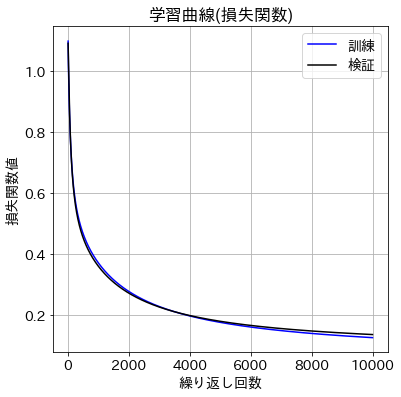

In [48]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

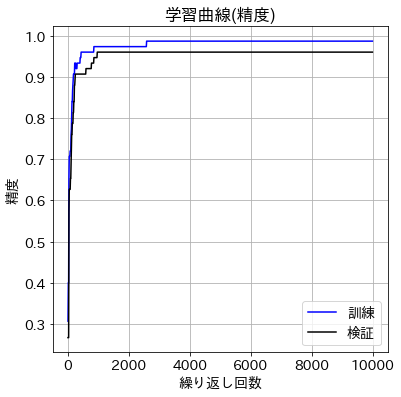

In [49]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## コラム softmax 関数と交差エントロピー関数の微妙な関係

### パターン1 モデルクラス側にlogsoftmax関数を含める

In [50]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.softmax = nn.LogSoftmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [51]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： NLLLoss
criterion = nn.NLLLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [52]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ
    with torch.no_grad():

        # 順伝搬計算
        outputs_test = net(inputs_test)

        # 誤差計算
        # loss_test = criterion(torch.log(outputs_test), labels_test)
        loss_test = criterion(outputs_test, labels_test)

        #予測値算出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss =  loss_test.item()
        val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

Epoch [1180/10000], loss: 0.34848 acc: 0.97333 val_loss: 0.33866, val_acc: 0.96000
Epoch [1190/10000], loss: 0.34732 acc: 0.97333 val_loss: 0.33757, val_acc: 0.96000
Epoch [1200/10000], loss: 0.34618 acc: 0.97333 val_loss: 0.33649, val_acc: 0.96000
Epoch [1210/10000], loss: 0.34505 acc: 0.97333 val_loss: 0.33542, val_acc: 0.96000
Epoch [1220/10000], loss: 0.34393 acc: 0.97333 val_loss: 0.33435, val_acc: 0.96000
Epoch [1230/10000], loss: 0.34282 acc: 0.97333 val_loss: 0.33330, val_acc: 0.96000
Epoch [1240/10000], loss: 0.34172 acc: 0.97333 val_loss: 0.33226, val_acc: 0.96000
Epoch [1250/10000], loss: 0.34062 acc: 0.97333 val_loss: 0.33122, val_acc: 0.96000
Epoch [1260/10000], loss: 0.33954 acc: 0.97333 val_loss: 0.33020, val_acc: 0.96000
Epoch [1270/10000], loss: 0.33846 acc: 0.97333 val_loss: 0.32918, val_acc: 0.96000
Epoch [1280/10000], loss: 0.33740 acc: 0.97333 val_loss: 0.32817, val_acc: 0.96000
Epoch [1290/10000], loss: 0.33634 acc: 0.97333 val_loss: 0.32717, val_acc: 0.96000
Epoc

Epoch [2260/10000], loss: 0.26250 acc: 0.97333 val_loss: 0.25818, val_acc: 0.96000
Epoch [2270/10000], loss: 0.26195 acc: 0.97333 val_loss: 0.25767, val_acc: 0.96000
Epoch [2280/10000], loss: 0.26140 acc: 0.97333 val_loss: 0.25717, val_acc: 0.96000
Epoch [2290/10000], loss: 0.26086 acc: 0.97333 val_loss: 0.25666, val_acc: 0.96000
Epoch [2300/10000], loss: 0.26032 acc: 0.97333 val_loss: 0.25616, val_acc: 0.96000
Epoch [2310/10000], loss: 0.25978 acc: 0.97333 val_loss: 0.25567, val_acc: 0.96000
Epoch [2320/10000], loss: 0.25924 acc: 0.97333 val_loss: 0.25517, val_acc: 0.96000
Epoch [2330/10000], loss: 0.25871 acc: 0.97333 val_loss: 0.25468, val_acc: 0.96000
Epoch [2340/10000], loss: 0.25818 acc: 0.97333 val_loss: 0.25419, val_acc: 0.96000
Epoch [2350/10000], loss: 0.25766 acc: 0.97333 val_loss: 0.25371, val_acc: 0.96000
Epoch [2360/10000], loss: 0.25713 acc: 0.97333 val_loss: 0.25322, val_acc: 0.96000
Epoch [2370/10000], loss: 0.25661 acc: 0.97333 val_loss: 0.25274, val_acc: 0.96000
Epoc

Epoch [3450/10000], loss: 0.21330 acc: 0.98667 val_loss: 0.21312, val_acc: 0.96000
Epoch [3460/10000], loss: 0.21299 acc: 0.98667 val_loss: 0.21284, val_acc: 0.96000
Epoch [3470/10000], loss: 0.21268 acc: 0.98667 val_loss: 0.21256, val_acc: 0.96000
Epoch [3480/10000], loss: 0.21238 acc: 0.98667 val_loss: 0.21228, val_acc: 0.96000
Epoch [3490/10000], loss: 0.21207 acc: 0.98667 val_loss: 0.21200, val_acc: 0.96000
Epoch [3500/10000], loss: 0.21177 acc: 0.98667 val_loss: 0.21173, val_acc: 0.96000
Epoch [3510/10000], loss: 0.21146 acc: 0.98667 val_loss: 0.21145, val_acc: 0.96000
Epoch [3520/10000], loss: 0.21116 acc: 0.98667 val_loss: 0.21118, val_acc: 0.96000
Epoch [3530/10000], loss: 0.21086 acc: 0.98667 val_loss: 0.21091, val_acc: 0.96000
Epoch [3540/10000], loss: 0.21056 acc: 0.98667 val_loss: 0.21064, val_acc: 0.96000
Epoch [3550/10000], loss: 0.21026 acc: 0.98667 val_loss: 0.21037, val_acc: 0.96000
Epoch [3560/10000], loss: 0.20997 acc: 0.98667 val_loss: 0.21010, val_acc: 0.96000
Epoc

Epoch [4690/10000], loss: 0.18280 acc: 0.98667 val_loss: 0.18566, val_acc: 0.96000
Epoch [4700/10000], loss: 0.18260 acc: 0.98667 val_loss: 0.18549, val_acc: 0.96000
Epoch [4710/10000], loss: 0.18241 acc: 0.98667 val_loss: 0.18531, val_acc: 0.96000
Epoch [4720/10000], loss: 0.18221 acc: 0.98667 val_loss: 0.18514, val_acc: 0.96000
Epoch [4730/10000], loss: 0.18202 acc: 0.98667 val_loss: 0.18497, val_acc: 0.96000
Epoch [4740/10000], loss: 0.18183 acc: 0.98667 val_loss: 0.18480, val_acc: 0.96000
Epoch [4750/10000], loss: 0.18164 acc: 0.98667 val_loss: 0.18462, val_acc: 0.96000
Epoch [4760/10000], loss: 0.18144 acc: 0.98667 val_loss: 0.18445, val_acc: 0.96000
Epoch [4770/10000], loss: 0.18125 acc: 0.98667 val_loss: 0.18428, val_acc: 0.96000
Epoch [4780/10000], loss: 0.18106 acc: 0.98667 val_loss: 0.18411, val_acc: 0.96000
Epoch [4790/10000], loss: 0.18087 acc: 0.98667 val_loss: 0.18395, val_acc: 0.96000
Epoch [4800/10000], loss: 0.18068 acc: 0.98667 val_loss: 0.18378, val_acc: 0.96000
Epoc

Epoch [5790/10000], loss: 0.16459 acc: 0.98667 val_loss: 0.16952, val_acc: 0.96000
Epoch [5800/10000], loss: 0.16445 acc: 0.98667 val_loss: 0.16940, val_acc: 0.96000
Epoch [5810/10000], loss: 0.16431 acc: 0.98667 val_loss: 0.16927, val_acc: 0.96000
Epoch [5820/10000], loss: 0.16417 acc: 0.98667 val_loss: 0.16915, val_acc: 0.96000
Epoch [5830/10000], loss: 0.16403 acc: 0.98667 val_loss: 0.16903, val_acc: 0.96000
Epoch [5840/10000], loss: 0.16389 acc: 0.98667 val_loss: 0.16891, val_acc: 0.96000
Epoch [5850/10000], loss: 0.16375 acc: 0.98667 val_loss: 0.16878, val_acc: 0.96000
Epoch [5860/10000], loss: 0.16361 acc: 0.98667 val_loss: 0.16866, val_acc: 0.96000
Epoch [5870/10000], loss: 0.16348 acc: 0.98667 val_loss: 0.16854, val_acc: 0.96000
Epoch [5880/10000], loss: 0.16334 acc: 0.98667 val_loss: 0.16842, val_acc: 0.96000
Epoch [5890/10000], loss: 0.16320 acc: 0.98667 val_loss: 0.16830, val_acc: 0.96000
Epoch [5900/10000], loss: 0.16307 acc: 0.98667 val_loss: 0.16818, val_acc: 0.96000
Epoc

Epoch [6870/10000], loss: 0.15139 acc: 0.98667 val_loss: 0.15798, val_acc: 0.96000
Epoch [6880/10000], loss: 0.15129 acc: 0.98667 val_loss: 0.15789, val_acc: 0.96000
Epoch [6890/10000], loss: 0.15118 acc: 0.98667 val_loss: 0.15780, val_acc: 0.96000
Epoch [6900/10000], loss: 0.15108 acc: 0.98667 val_loss: 0.15771, val_acc: 0.96000
Epoch [6910/10000], loss: 0.15097 acc: 0.98667 val_loss: 0.15761, val_acc: 0.96000
Epoch [6920/10000], loss: 0.15086 acc: 0.98667 val_loss: 0.15752, val_acc: 0.96000
Epoch [6930/10000], loss: 0.15076 acc: 0.98667 val_loss: 0.15743, val_acc: 0.96000
Epoch [6940/10000], loss: 0.15065 acc: 0.98667 val_loss: 0.15734, val_acc: 0.96000
Epoch [6950/10000], loss: 0.15055 acc: 0.98667 val_loss: 0.15725, val_acc: 0.96000
Epoch [6960/10000], loss: 0.15045 acc: 0.98667 val_loss: 0.15716, val_acc: 0.96000
Epoch [6970/10000], loss: 0.15034 acc: 0.98667 val_loss: 0.15707, val_acc: 0.96000
Epoch [6980/10000], loss: 0.15024 acc: 0.98667 val_loss: 0.15698, val_acc: 0.96000
Epoc

Epoch [7960/10000], loss: 0.14112 acc: 0.98667 val_loss: 0.14912, val_acc: 0.96000
Epoch [7970/10000], loss: 0.14103 acc: 0.98667 val_loss: 0.14904, val_acc: 0.96000
Epoch [7980/10000], loss: 0.14095 acc: 0.98667 val_loss: 0.14897, val_acc: 0.96000
Epoch [7990/10000], loss: 0.14087 acc: 0.98667 val_loss: 0.14890, val_acc: 0.96000
Epoch [8000/10000], loss: 0.14078 acc: 0.98667 val_loss: 0.14883, val_acc: 0.96000
Epoch [8010/10000], loss: 0.14070 acc: 0.98667 val_loss: 0.14876, val_acc: 0.96000
Epoch [8020/10000], loss: 0.14062 acc: 0.98667 val_loss: 0.14869, val_acc: 0.96000
Epoch [8030/10000], loss: 0.14054 acc: 0.98667 val_loss: 0.14862, val_acc: 0.96000
Epoch [8040/10000], loss: 0.14045 acc: 0.98667 val_loss: 0.14855, val_acc: 0.96000
Epoch [8050/10000], loss: 0.14037 acc: 0.98667 val_loss: 0.14848, val_acc: 0.96000
Epoch [8060/10000], loss: 0.14029 acc: 0.98667 val_loss: 0.14841, val_acc: 0.96000
Epoch [8070/10000], loss: 0.14021 acc: 0.98667 val_loss: 0.14834, val_acc: 0.96000
Epoc

Epoch [8960/10000], loss: 0.13354 acc: 0.98667 val_loss: 0.14266, val_acc: 0.96000
Epoch [8970/10000], loss: 0.13347 acc: 0.98667 val_loss: 0.14261, val_acc: 0.96000
Epoch [8980/10000], loss: 0.13341 acc: 0.98667 val_loss: 0.14255, val_acc: 0.96000
Epoch [8990/10000], loss: 0.13334 acc: 0.98667 val_loss: 0.14249, val_acc: 0.96000
Epoch [9000/10000], loss: 0.13327 acc: 0.98667 val_loss: 0.14243, val_acc: 0.96000
Epoch [9010/10000], loss: 0.13320 acc: 0.98667 val_loss: 0.14238, val_acc: 0.96000
Epoch [9020/10000], loss: 0.13313 acc: 0.98667 val_loss: 0.14232, val_acc: 0.96000
Epoch [9030/10000], loss: 0.13307 acc: 0.98667 val_loss: 0.14226, val_acc: 0.96000
Epoch [9040/10000], loss: 0.13300 acc: 0.98667 val_loss: 0.14220, val_acc: 0.96000
Epoch [9050/10000], loss: 0.13293 acc: 0.98667 val_loss: 0.14215, val_acc: 0.96000
Epoch [9060/10000], loss: 0.13286 acc: 0.98667 val_loss: 0.14209, val_acc: 0.96000
Epoch [9070/10000], loss: 0.13280 acc: 0.98667 val_loss: 0.14203, val_acc: 0.96000
Epoc

Epoch [9970/10000], loss: 0.12720 acc: 0.98667 val_loss: 0.13733, val_acc: 0.96000
Epoch [9980/10000], loss: 0.12715 acc: 0.98667 val_loss: 0.13728, val_acc: 0.96000
Epoch [9990/10000], loss: 0.12709 acc: 0.98667 val_loss: 0.13724, val_acc: 0.96000


In [53]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


In [54]:
# パターン1モデルの出力結果
w = outputs[:5,:].data
print(w.numpy())

# 確率値を得たい場合
print(torch.exp(w).numpy())

[[ -5.1283  -0.0992  -2.4251]
 [ -4.9799  -0.021   -4.274 ]
 [ -0.0563  -2.9047 -16.2378]
 [-11.7813  -3.2099  -0.0412]
 [ -9.2329  -1.747   -0.1916]]
[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]


### パターン2 モデルクラス側は素のsoftmax

In [55]:
# モデルの定義
# 2入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        # softmax関数の定義
        self.softmax = nn.Softmax(dim=1)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.softmax(x1)
        return x2

In [56]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： NLLLoss
criterion = nn.NLLLoss()

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [57]:
for epoch in range(num_epochs):

    # 学習フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 順伝搬計算
    outputs = net(inputs)
    
    # ここで対数関数にかける
    outputs2 = torch.log(outputs)

    # 誤差計算
    loss = criterion(outputs2, labels)

    # 勾配計算
    loss.backward()
    
    # 重み調整
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 訓練データに対する損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ
    with torch.no_grad():

        # 順伝搬計算
        outputs_test = net(inputs_test)
        
        # ここで対数関数にかける
        outputs2_test = torch.log(outputs_test)

        # 誤差計算
        loss_test = criterion(outputs2_test, labels_test)

        #予測値算出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 検証データに対する損失と精度の計算
        val_loss =  loss_test.item()
        val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

Epoch [1060/10000], loss: 0.36311 acc: 0.97333 val_loss: 0.35258, val_acc: 0.96000
Epoch [1070/10000], loss: 0.36183 acc: 0.97333 val_loss: 0.35135, val_acc: 0.96000
Epoch [1080/10000], loss: 0.36056 acc: 0.97333 val_loss: 0.35014, val_acc: 0.96000
Epoch [1090/10000], loss: 0.35930 acc: 0.97333 val_loss: 0.34895, val_acc: 0.96000
Epoch [1100/10000], loss: 0.35805 acc: 0.97333 val_loss: 0.34776, val_acc: 0.96000
Epoch [1110/10000], loss: 0.35682 acc: 0.97333 val_loss: 0.34659, val_acc: 0.96000
Epoch [1120/10000], loss: 0.35559 acc: 0.97333 val_loss: 0.34542, val_acc: 0.96000
Epoch [1130/10000], loss: 0.35438 acc: 0.97333 val_loss: 0.34427, val_acc: 0.96000
Epoch [1140/10000], loss: 0.35318 acc: 0.97333 val_loss: 0.34313, val_acc: 0.96000
Epoch [1150/10000], loss: 0.35199 acc: 0.97333 val_loss: 0.34199, val_acc: 0.96000
Epoch [1160/10000], loss: 0.35081 acc: 0.97333 val_loss: 0.34087, val_acc: 0.96000
Epoch [1170/10000], loss: 0.34964 acc: 0.97333 val_loss: 0.33976, val_acc: 0.96000
Epoc

Epoch [2190/10000], loss: 0.26644 acc: 0.97333 val_loss: 0.26182, val_acc: 0.96000
Epoch [2200/10000], loss: 0.26587 acc: 0.97333 val_loss: 0.26129, val_acc: 0.96000
Epoch [2210/10000], loss: 0.26530 acc: 0.97333 val_loss: 0.26077, val_acc: 0.96000
Epoch [2220/10000], loss: 0.26473 acc: 0.97333 val_loss: 0.26024, val_acc: 0.96000
Epoch [2230/10000], loss: 0.26417 acc: 0.97333 val_loss: 0.25972, val_acc: 0.96000
Epoch [2240/10000], loss: 0.26361 acc: 0.97333 val_loss: 0.25921, val_acc: 0.96000
Epoch [2250/10000], loss: 0.26305 acc: 0.97333 val_loss: 0.25869, val_acc: 0.96000
Epoch [2260/10000], loss: 0.26250 acc: 0.97333 val_loss: 0.25818, val_acc: 0.96000
Epoch [2270/10000], loss: 0.26195 acc: 0.97333 val_loss: 0.25767, val_acc: 0.96000
Epoch [2280/10000], loss: 0.26140 acc: 0.97333 val_loss: 0.25717, val_acc: 0.96000
Epoch [2290/10000], loss: 0.26086 acc: 0.97333 val_loss: 0.25666, val_acc: 0.96000
Epoch [2300/10000], loss: 0.26032 acc: 0.97333 val_loss: 0.25616, val_acc: 0.96000
Epoc

Epoch [3380/10000], loss: 0.21550 acc: 0.98667 val_loss: 0.21511, val_acc: 0.96000
Epoch [3390/10000], loss: 0.21518 acc: 0.98667 val_loss: 0.21483, val_acc: 0.96000
Epoch [3400/10000], loss: 0.21487 acc: 0.98667 val_loss: 0.21454, val_acc: 0.96000
Epoch [3410/10000], loss: 0.21455 acc: 0.98667 val_loss: 0.21425, val_acc: 0.96000
Epoch [3420/10000], loss: 0.21424 acc: 0.98667 val_loss: 0.21397, val_acc: 0.96000
Epoch [3430/10000], loss: 0.21392 acc: 0.98667 val_loss: 0.21368, val_acc: 0.96000
Epoch [3440/10000], loss: 0.21361 acc: 0.98667 val_loss: 0.21340, val_acc: 0.96000
Epoch [3450/10000], loss: 0.21330 acc: 0.98667 val_loss: 0.21312, val_acc: 0.96000
Epoch [3460/10000], loss: 0.21299 acc: 0.98667 val_loss: 0.21284, val_acc: 0.96000
Epoch [3470/10000], loss: 0.21268 acc: 0.98667 val_loss: 0.21256, val_acc: 0.96000
Epoch [3480/10000], loss: 0.21238 acc: 0.98667 val_loss: 0.21228, val_acc: 0.96000
Epoch [3490/10000], loss: 0.21207 acc: 0.98667 val_loss: 0.21200, val_acc: 0.96000
Epoc

Epoch [4590/10000], loss: 0.18478 acc: 0.98667 val_loss: 0.18743, val_acc: 0.96000
Epoch [4600/10000], loss: 0.18458 acc: 0.98667 val_loss: 0.18725, val_acc: 0.96000
Epoch [4610/10000], loss: 0.18438 acc: 0.98667 val_loss: 0.18707, val_acc: 0.96000
Epoch [4620/10000], loss: 0.18418 acc: 0.98667 val_loss: 0.18690, val_acc: 0.96000
Epoch [4630/10000], loss: 0.18398 acc: 0.98667 val_loss: 0.18672, val_acc: 0.96000
Epoch [4640/10000], loss: 0.18378 acc: 0.98667 val_loss: 0.18654, val_acc: 0.96000
Epoch [4650/10000], loss: 0.18358 acc: 0.98667 val_loss: 0.18636, val_acc: 0.96000
Epoch [4660/10000], loss: 0.18339 acc: 0.98667 val_loss: 0.18619, val_acc: 0.96000
Epoch [4670/10000], loss: 0.18319 acc: 0.98667 val_loss: 0.18601, val_acc: 0.96000
Epoch [4680/10000], loss: 0.18299 acc: 0.98667 val_loss: 0.18583, val_acc: 0.96000
Epoch [4690/10000], loss: 0.18280 acc: 0.98667 val_loss: 0.18566, val_acc: 0.96000
Epoch [4700/10000], loss: 0.18260 acc: 0.98667 val_loss: 0.18549, val_acc: 0.96000
Epoc

Epoch [5790/10000], loss: 0.16459 acc: 0.98667 val_loss: 0.16952, val_acc: 0.96000
Epoch [5800/10000], loss: 0.16445 acc: 0.98667 val_loss: 0.16940, val_acc: 0.96000
Epoch [5810/10000], loss: 0.16431 acc: 0.98667 val_loss: 0.16927, val_acc: 0.96000
Epoch [5820/10000], loss: 0.16417 acc: 0.98667 val_loss: 0.16915, val_acc: 0.96000
Epoch [5830/10000], loss: 0.16403 acc: 0.98667 val_loss: 0.16903, val_acc: 0.96000
Epoch [5840/10000], loss: 0.16389 acc: 0.98667 val_loss: 0.16891, val_acc: 0.96000
Epoch [5850/10000], loss: 0.16375 acc: 0.98667 val_loss: 0.16878, val_acc: 0.96000
Epoch [5860/10000], loss: 0.16361 acc: 0.98667 val_loss: 0.16866, val_acc: 0.96000
Epoch [5870/10000], loss: 0.16348 acc: 0.98667 val_loss: 0.16854, val_acc: 0.96000
Epoch [5880/10000], loss: 0.16334 acc: 0.98667 val_loss: 0.16842, val_acc: 0.96000
Epoch [5890/10000], loss: 0.16320 acc: 0.98667 val_loss: 0.16830, val_acc: 0.96000
Epoch [5900/10000], loss: 0.16307 acc: 0.98667 val_loss: 0.16818, val_acc: 0.96000
Epoc

Epoch [6990/10000], loss: 0.15013 acc: 0.98667 val_loss: 0.15689, val_acc: 0.96000
Epoch [7000/10000], loss: 0.15003 acc: 0.98667 val_loss: 0.15680, val_acc: 0.96000
Epoch [7010/10000], loss: 0.14993 acc: 0.98667 val_loss: 0.15671, val_acc: 0.96000
Epoch [7020/10000], loss: 0.14983 acc: 0.98667 val_loss: 0.15662, val_acc: 0.96000
Epoch [7030/10000], loss: 0.14972 acc: 0.98667 val_loss: 0.15653, val_acc: 0.96000
Epoch [7040/10000], loss: 0.14962 acc: 0.98667 val_loss: 0.15644, val_acc: 0.96000
Epoch [7050/10000], loss: 0.14952 acc: 0.98667 val_loss: 0.15636, val_acc: 0.96000
Epoch [7060/10000], loss: 0.14942 acc: 0.98667 val_loss: 0.15627, val_acc: 0.96000
Epoch [7070/10000], loss: 0.14931 acc: 0.98667 val_loss: 0.15618, val_acc: 0.96000
Epoch [7080/10000], loss: 0.14921 acc: 0.98667 val_loss: 0.15609, val_acc: 0.96000
Epoch [7090/10000], loss: 0.14911 acc: 0.98667 val_loss: 0.15600, val_acc: 0.96000
Epoch [7100/10000], loss: 0.14901 acc: 0.98667 val_loss: 0.15592, val_acc: 0.96000
Epoc

Epoch [8110/10000], loss: 0.13988 acc: 0.98667 val_loss: 0.14806, val_acc: 0.96000
Epoch [8120/10000], loss: 0.13980 acc: 0.98667 val_loss: 0.14799, val_acc: 0.96000
Epoch [8130/10000], loss: 0.13972 acc: 0.98667 val_loss: 0.14792, val_acc: 0.96000
Epoch [8140/10000], loss: 0.13964 acc: 0.98667 val_loss: 0.14785, val_acc: 0.96000
Epoch [8150/10000], loss: 0.13956 acc: 0.98667 val_loss: 0.14778, val_acc: 0.96000
Epoch [8160/10000], loss: 0.13948 acc: 0.98667 val_loss: 0.14771, val_acc: 0.96000
Epoch [8170/10000], loss: 0.13940 acc: 0.98667 val_loss: 0.14765, val_acc: 0.96000
Epoch [8180/10000], loss: 0.13932 acc: 0.98667 val_loss: 0.14758, val_acc: 0.96000
Epoch [8190/10000], loss: 0.13924 acc: 0.98667 val_loss: 0.14751, val_acc: 0.96000
Epoch [8200/10000], loss: 0.13916 acc: 0.98667 val_loss: 0.14744, val_acc: 0.96000
Epoch [8210/10000], loss: 0.13908 acc: 0.98667 val_loss: 0.14737, val_acc: 0.96000
Epoch [8220/10000], loss: 0.13900 acc: 0.98667 val_loss: 0.14731, val_acc: 0.96000
Epoc

Epoch [9200/10000], loss: 0.13193 acc: 0.98667 val_loss: 0.14130, val_acc: 0.96000
Epoch [9210/10000], loss: 0.13187 acc: 0.98667 val_loss: 0.14125, val_acc: 0.96000
Epoch [9220/10000], loss: 0.13180 acc: 0.98667 val_loss: 0.14119, val_acc: 0.96000
Epoch [9230/10000], loss: 0.13174 acc: 0.98667 val_loss: 0.14114, val_acc: 0.96000
Epoch [9240/10000], loss: 0.13167 acc: 0.98667 val_loss: 0.14108, val_acc: 0.96000
Epoch [9250/10000], loss: 0.13160 acc: 0.98667 val_loss: 0.14103, val_acc: 0.96000
Epoch [9260/10000], loss: 0.13154 acc: 0.98667 val_loss: 0.14097, val_acc: 0.96000
Epoch [9270/10000], loss: 0.13147 acc: 0.98667 val_loss: 0.14092, val_acc: 0.96000
Epoch [9280/10000], loss: 0.13141 acc: 0.98667 val_loss: 0.14086, val_acc: 0.96000
Epoch [9290/10000], loss: 0.13135 acc: 0.98667 val_loss: 0.14081, val_acc: 0.96000
Epoch [9300/10000], loss: 0.13128 acc: 0.98667 val_loss: 0.14075, val_acc: 0.96000
Epoch [9310/10000], loss: 0.13122 acc: 0.98667 val_loss: 0.14070, val_acc: 0.96000
Epoc

In [58]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 1.09158 精度: 0.26667
最終状態: 損失関数: 0.13724 精度: 0.96000


In [59]:
w = outputs[:5,:].data.numpy()
print(w)

[[0.0059 0.9056 0.0885]
 [0.0069 0.9792 0.0139]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]
 [0.0001 0.1743 0.8256]]
